## External packages

In [7]:
%matplotlib inline

import platform, sys
print(f"Python: {platform.platform()}, version: {sys.version[0:6]}")

import numpy as np
import pandas as pd
import seaborn as sns
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")

from sklearn import datasets
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 

# plotting library
import matplotlib
import matplotlib.pyplot as plt 
print(f"matplotlib: {matplotlib.__version__}")

# ML-models library
import sklearn as sk
print(f"scikit-learn: {sk.__version__}")

# statistics library
import statsmodels
print(f"statsmodels: {statsmodels.__version__}")

import ast

Python: Windows-11-10.0.26100-SP0, version: 3.12.7
numpy: 1.26.4
pandas: 2.2.2
seaborn: 0.13.2
matplotlib: 3.9.2
scikit-learn: 1.5.1
statsmodels: 0.14.2


## Load dataset

In [8]:
import os

def load_csv_pd_data(path, filename):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel csv-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} does not exist")

    return pd.read_csv(csv_path, sep=';')


def load_movies():
    '''
    load_movies() - construct a pandas DataFrame object of the movies
            with all the normal numeric fields formatted to be
            accepted by matplotlib, with a weighted average field for the votes,
            and with unused fields already removed.  
    @returns: a pandas DataFrame
    '''
    movies = load_csv_pd_data("input", "data_movies_clean.csv")

    # Format fields.
    movies['vote_average'] = movies['vote_average'].str.replace(',', '.').astype(float)
    movies['budget'] = movies['budget'].str.replace(',', '.').astype(float)
    movies['revenue'] = movies['revenue'].str.replace(',', '.').astype(float)
    movies['release_date'] = pd.to_datetime(movies['release_date'], format='mixed')

    # Drop unused fields.
    movies = movies.drop(['title', 'adult', 'popularity'], axis=1)

    # Merge vote_average and vote_count -> weighted_vote.
    C = movies['vote_average'].mean()
    m = movies['vote_count'].quantile(0.80)

    v = movies['vote_count']
    R = movies['vote_average']

    movies['weighted_vote'] = np.where(
        (v > 0) & (R > 0), (v / (v + m)) * R + (m / (v + m)) * C, 0
    )

    return movies



movies = load_movies()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946460 entries, 0 to 946459
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        946460 non-null  int64         
 1   original_language         946460 non-null  object        
 2   origin_country            946460 non-null  object        
 3   release_date              946460 non-null  datetime64[ns]
 4   genre_names               946460 non-null  object        
 5   production_company_names  946460 non-null  object        
 6   budget                    946460 non-null  float64       
 7   revenue                   946460 non-null  float64       
 8   runtime                   946460 non-null  int64         
 9   vote_average              946460 non-null  float64       
 10  vote_count                946460 non-null  int64         
 11  weighted_vote             946460 non-null  float64       
dtypes:

---

## Uitwerking verdelingen

 - Lineare regressie zal worden uitgewerkt door Laurens.
 - Random forest zal worden uitgewerkt door Dustin.

Met de uitkomsten van deze twee modellen hopen wij verder te kunnen werken met Polynomial regression en eventueel Gradient Boosting. Hiervoor hebben wij nog geen verdeling, en we hopen samen te werken hiervoor

## Feature Engineering: Categoriale Variabelen

Om de niet-numerieke, **categoriale variabelen** te kunnen analyseren en te gebruiken voor correlatie- en modeltraining, worden deze bewerkt naar een numeriek formaat (Feature Engineering).

### Genres (Binary Encoding)
Aangezien een film meerdere genres kan hebben (multi-label), wordt Binary Encoding gebruikt om elke unieke combinatie vast te leggen.
* Elk genre krijgt een unieke waarde als een exponent van 2 (bijvoorbeeld: 1, 2, 4, 8, ...).
* De kolom `genre_numeric` bevat de som van deze waarden, wat uniek is voor elke combinatie van genres.

### Landen van Oorsprong (`origin_country`) (Hashing)
Er is een zeer groot aantal unieke combinaties van productielanden. Om te voorkomen dat er te veel spaarzame kolommen ontstaan, wordt gekozen voor Hashing. De unieke combinatie van landen wordt omgezet naar een numerieke hashwaarde (`country_hash`).

### Originele Taal (`original_language`) (Label Encoding)
De originele taal is een enkel, discreet veld. Er wordt een eenvoudige Label Encoding (indexering) toegepast, waarbij elke unieke taal een integer index krijgt (`original_language_numeric`).

In [9]:
LANGUAGES = ['aa', 'ab', 'af', 'ak', 'am', 'an', 'ar', 'as', 'av', 'ay', 'az', 'ba', 'be', 'bg', 'bi', 'bm', 'bn', 'bo', 'br', 'bs', 'ca', 'ce', 'ch', 'cn', 'co', 'cr', 'cs', 'cv', 'cy', 'da', 'de', 'dv', 'dz', 'ee', 'el', 'en', 'eo', 'es', 'et', 'eu', 'fa', 'ff', 'fi', 'fj', 'fo', 'fr', 'fy', 'ga', 'gd', 'gl', 'gn', 'gu', 'gv', 'ha', 'he', 'hi', 'ho', 'hr', 'ht', 'hu', 'hy', 'hz', 'ia', 'id', 'ie', 'ig', 'ik', 'io', 'is', 'it', 'iu', 'ja', 'jv', 'ka', 'kg', 'ki', 'kj', 'kk', 'kl', 'km', 'kn', 'ko', 'ks', 'ku', 'kv', 'kw', 'ky', 'la', 'lb', 'lg', 'li', 'ln', 'lo', 'lt', 'lv', 'mg', 'mh', 'mi', 'mk', 'ml', 'mn', 'mo', 'mr', 'ms', 'mt', 'my', 'nb', 'nd', 'ne', 'ng', 'nl', 'nn', 'no', 'nr', 'nv', 'ny', 'oc', 'oj', 'om', 'or', 'os', 'pa', 'pl', 'ps', 'pt', 'qu', 'rm', 'rn', 'ro', 'ru', 'rw', 'sa', 'sc', 'sd', 'se', 'sg', 'sh', 'si', 'sk', 'sl', 'sm', 'sn', 'so', 'sq', 'sr', 'ss', 'st', 'su', 'sv', 'sw', 'ta', 'te', 'tg', 'th', 'ti', 'tk', 'tl', 'tn', 'to', 'tr', 'ts', 'tt', 'tw', 'ty', 'ug', 'uk', 'ur', 'uz', 've', 'vi', 'wo', 'xh', 'xx', 'yi', 'yo', 'za', 'zh', 'zu']
GENRES = {'History', 'Action', 'Thriller', 'Science Fiction', 'Documentary', 'Western', 'Family', 'Drama', 'Fantasy', 'Comedy', 'Romance', 'TV Movie', 'Mystery', 'Adventure', 'Crime', 'Animation', 'Horror', 'Music', 'War'}

# Genres.
genres_values = {genre: 1 << i for i, genre in enumerate(sorted(GENRES))}

movies["genre_names"] = movies["genre_names"].apply(ast.literal_eval)
movies["genre_numeric"] = movies["genre_names"].apply(lambda row: sum(genres_values[key] for key in row))

# Countries.
movies["origin_country"] = movies["origin_country"].apply(ast.literal_eval)
movies["country_hash"] = movies["origin_country"].apply(lambda row: hash(tuple(sorted(row))))

# Languages.
movies["original_language_numeric"] = movies["original_language"].apply(lambda row: LANGUAGES.index(row))

movies.head()



,id,original_language,origin_country,release_date,genre_names,production_company_names,budget,revenue,runtime,vote_average,vote_count,weighted_vote,genre_numeric,country_hash,original_language_numeric
0,1434045,es,[CL],1900-01-01,[],[],1979.979975,1135.539106,0,0.0,0,0.0,0,-2110824289635250640,37
1,1380119,en,[US],1900-01-01,[],['British Mutoscope and Biograph Company'],1976.326173,1258.533539,1,0.0,0,0.0,0,1717798398817769761,35
2,1382564,xx,[IE],1900-01-01,[Documentary],['British Mutoscope and Biograph Company'],2381.013930,1628.939539,1,0.0,0,0.0,32,-8132572483981109975,172
3,1362831,en,[US],1900-01-01,[Documentary],['American Mutoscope & Biograph'],3979.708686,2869.141435,1,0.0,0,0.0,32,1717798398817769761,35
4,1139794,en,[US],1900-01-01,[Documentary],['Warwick Trading Company'],1474.778149,830.322811,2,0.0,0,0.0,32,1717798398817769761,35


## Exploration

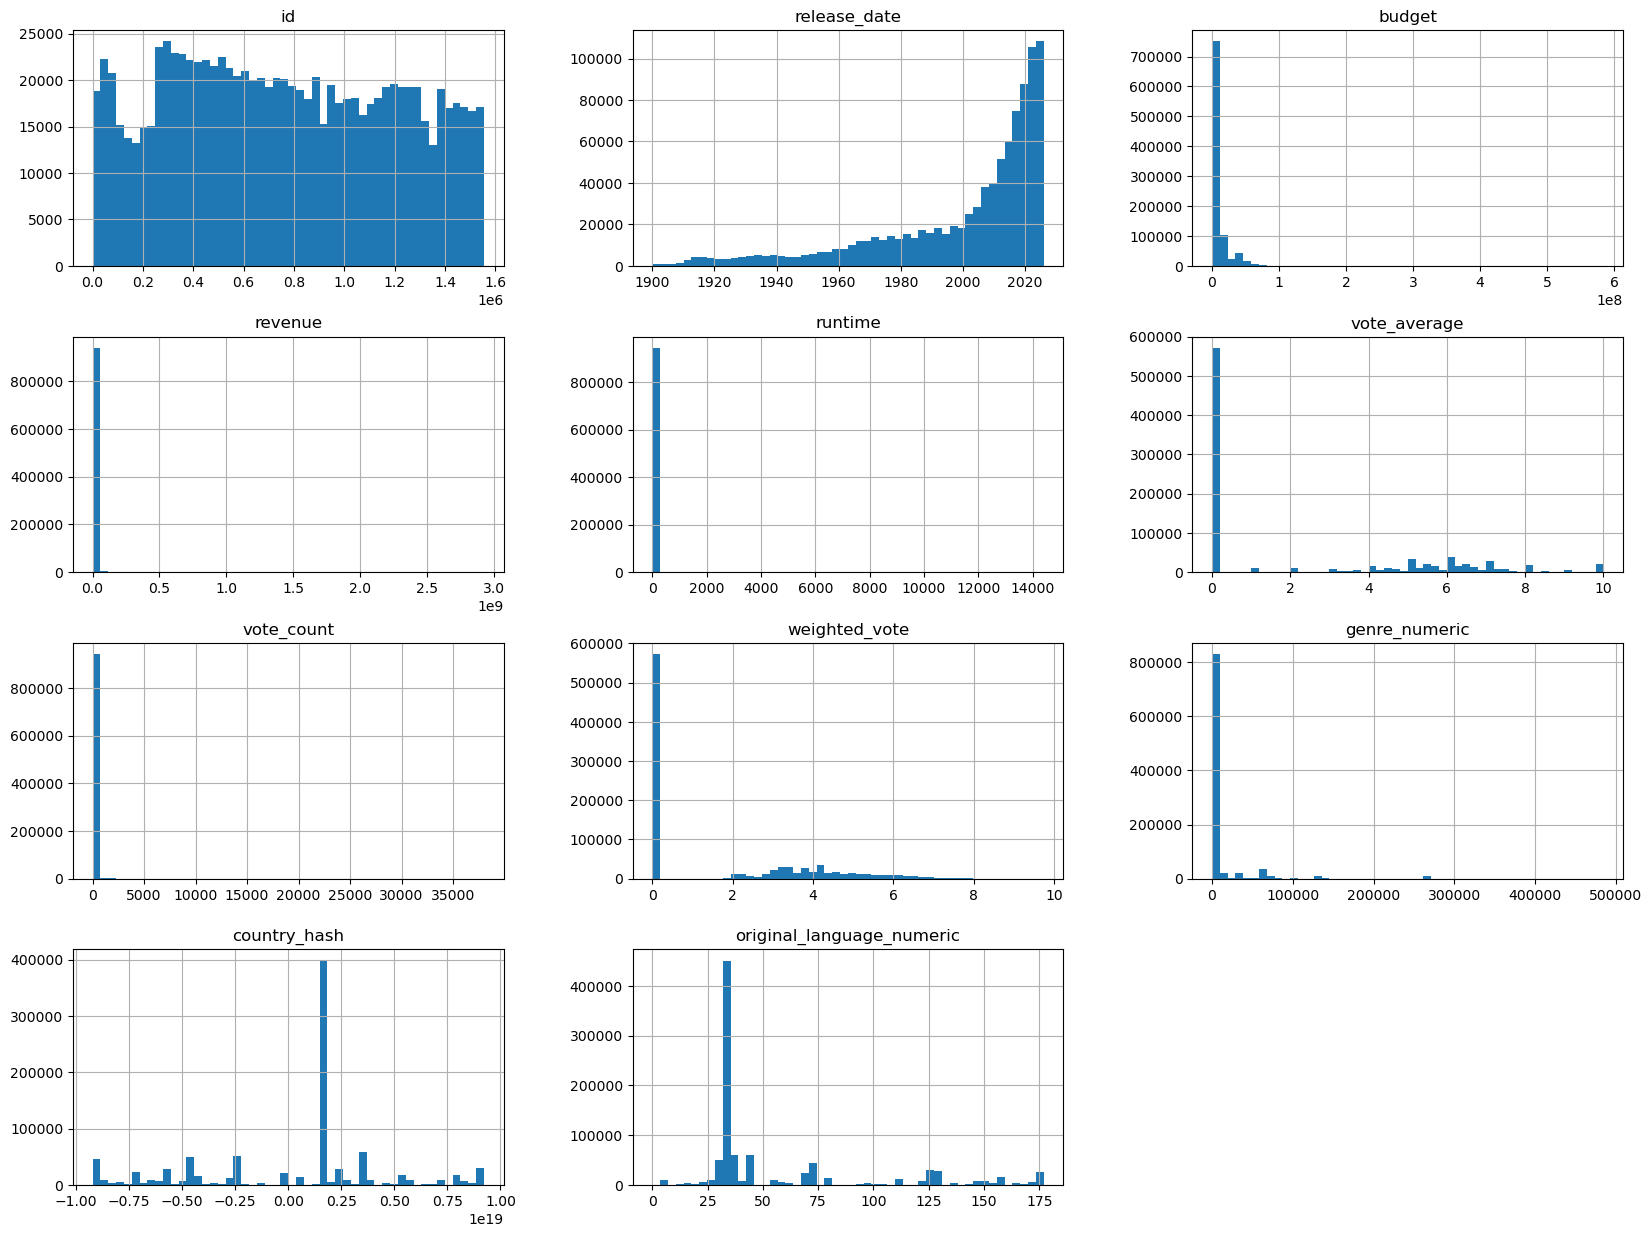

In [10]:
%matplotlib inline     


movies.hist(bins=50, figsize=(20,15))
plt.show() 

Hieruit zien we dat de null-waardes en andere outliers de gegevens te zwaar beinvloeden om echt bruikbaar te zijn. Het is daarom belangrijk dat we de data bewerken om de invloed van deze waardes te verminderen.

Movie count: 333686
Log=false


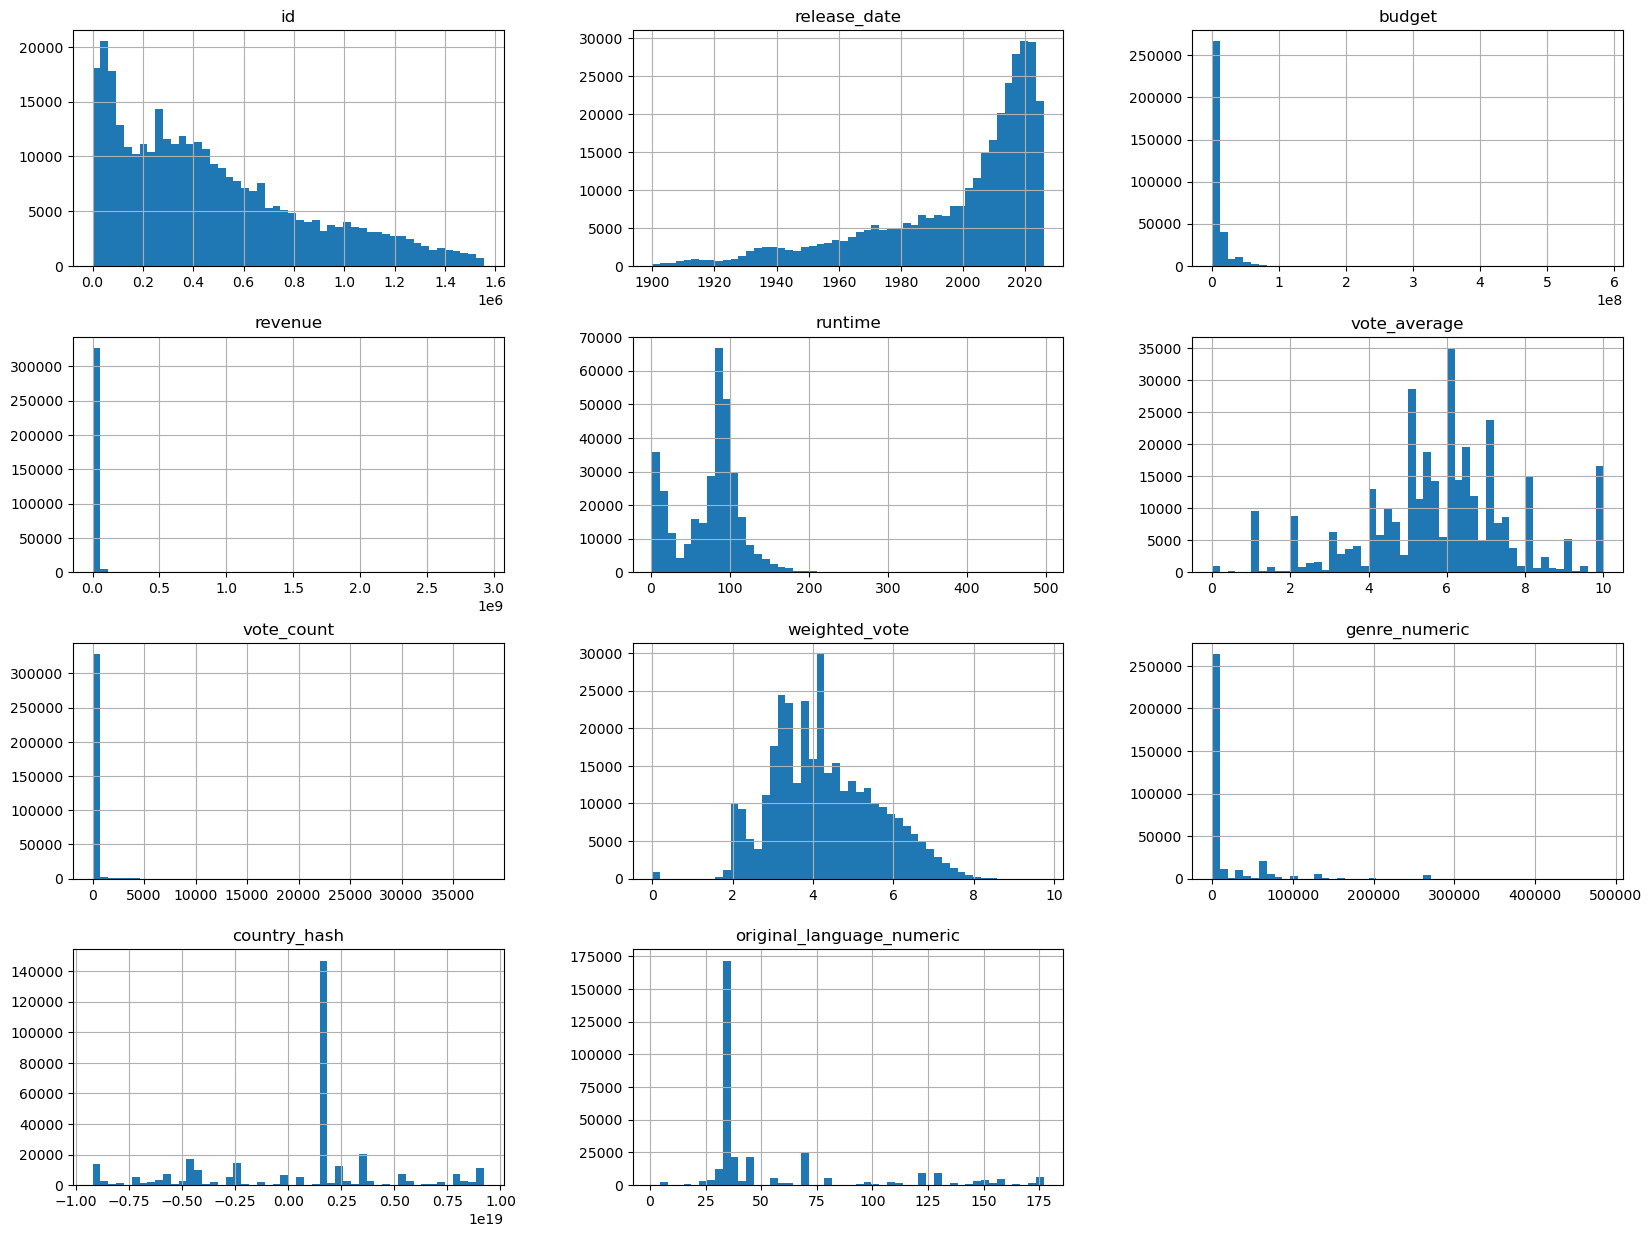

Log=true


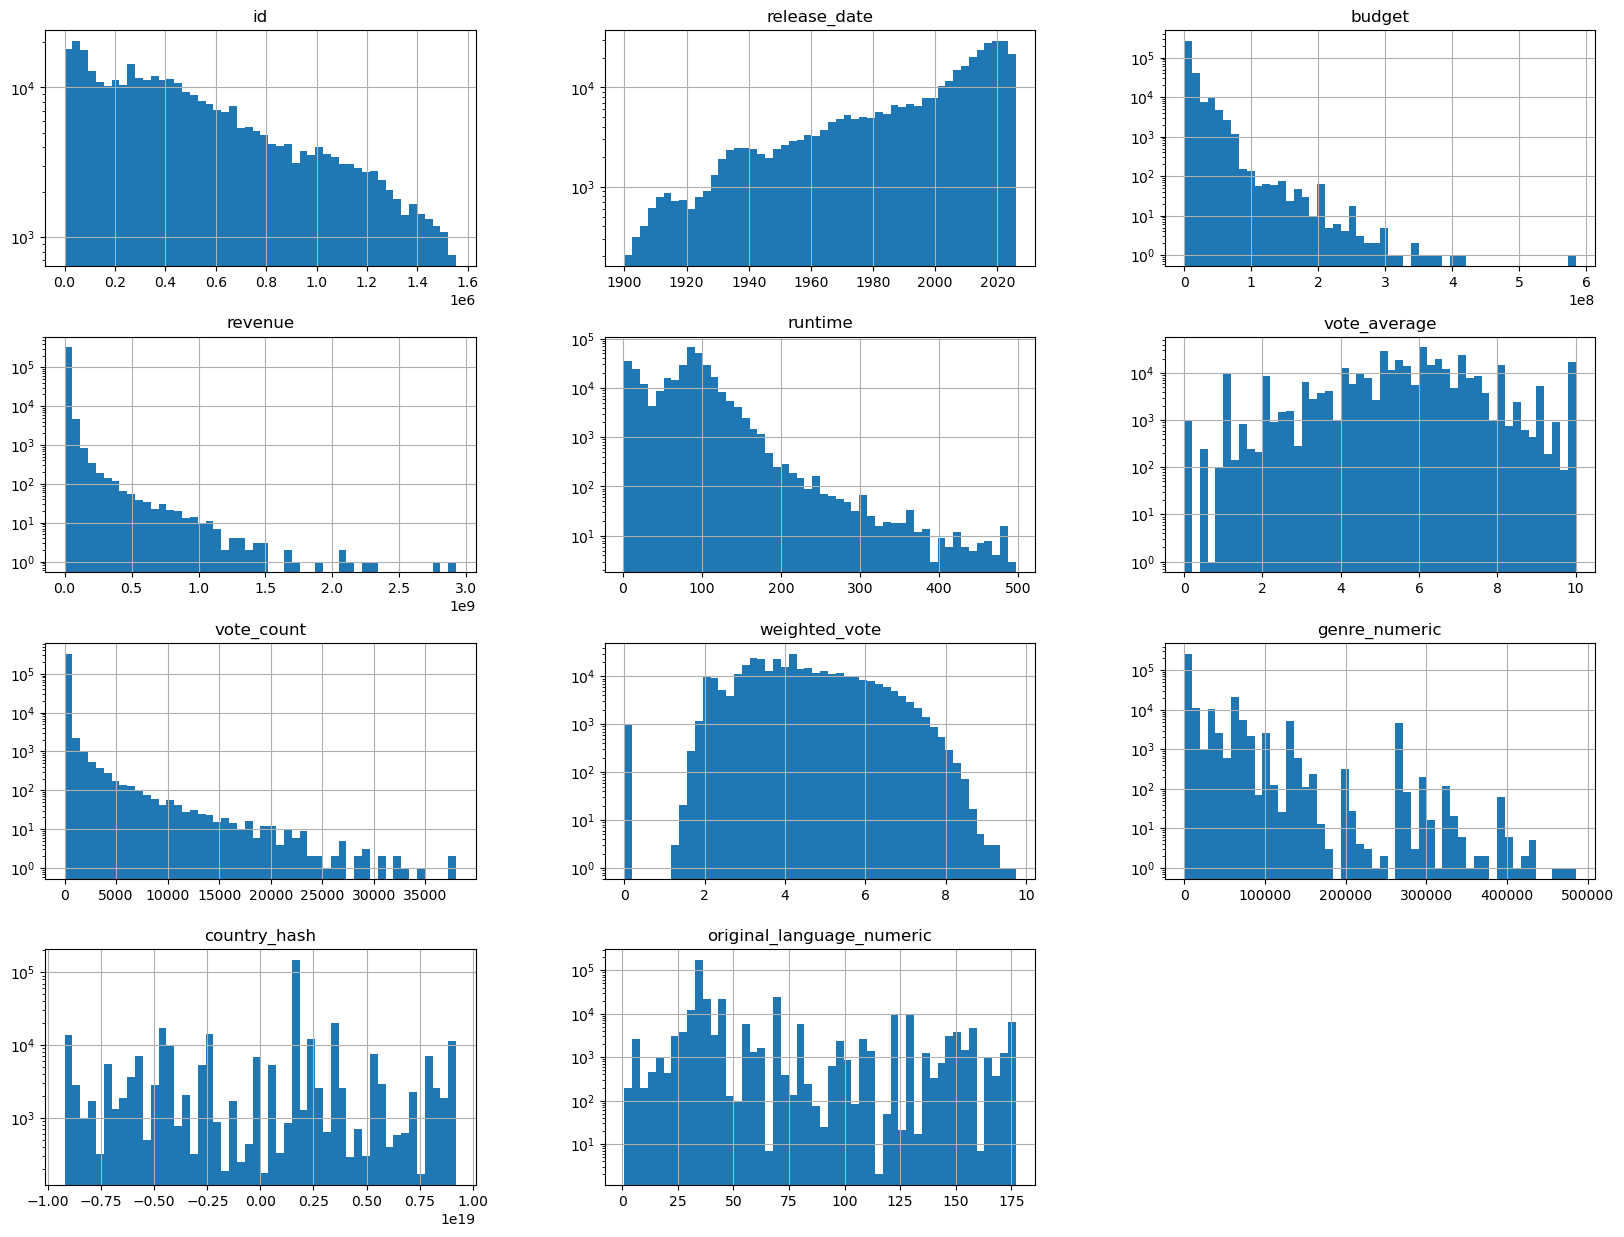

In [11]:
%matplotlib inline     

# Verwijder records waar runtime 0 of negatief is, of meer dan 300 minuten is.
movies.drop(movies[(movies['runtime'] <= 1) | (movies['runtime'] >= 500)].index, inplace=True)

# Verwijder records waar budget 1 of minder is.
movies.drop(movies[(movies['budget'] <= 1)].index, inplace=True)

# Je kan zien hoe revenue nog veel verschil heeft tussen de indie films, met outliers in de miljarden. 
# De grafiek is hierom biased. Echter is dit onze target dus is het minder relevant voor ons onderzoek.

# Dit gooit een heleboel records weg, van 750k naar 333k.
movies.drop(movies[(movies['vote_count'] < 1)].index, inplace=True)

print(f"Movie count: {len(movies)}")

print("Log=false")
movies.hist(bins=50, figsize=(20,15), log=False)
plt.show() 

print("Log=true")
movies.hist(bins=50, figsize=(20,15), log=True)
plt.show() 

Hierboven zien we twee varianten van dezelfde grafiek: één met een lineaire y-as en één met een logaritmische y-as. Omdat variabelen zoals revenue sterk scheef verdeeld zijn, met relatief veel lage waarden en een klein aantal extreem hoge blockbusteropbrengsten, zijn de kleinere waarden in de grafiek met een lineaire schaal nauwelijks zichtbaar. Door een logaritmische schaal te gebruiken worden zowel de lage als de hoge waarden beter vergelijkbaar en ontstaat een duidelijker beeld van de onderliggende verdeling.

## Heatmap

Hieronder wordt een heatmap gemaakt om in kaart te brengen welke predictors correlatie hebben met elkaar, zodat men makkelijk kan zien welke relevant zijn voor ons onderzoek.

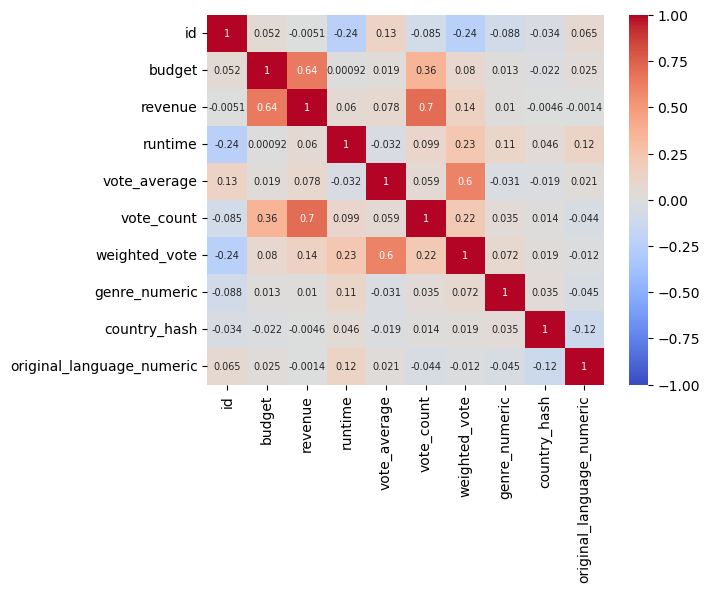

In [12]:
numeric_fields = movies.select_dtypes(include=['number'])

correlation = numeric_fields.corr()
axis_corr = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, cmap="coolwarm", annot=True, annot_kws={"size": 7})

plt.show()



In [ ]:
import os

output_dir = "output"
#check if ouptut exists, otherwise create it
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "movies_cleaned.csv")

# Write cleaned data to CSV
movies.to_csv(output_path, index=False)

print(f"Cleaned data written to {output_path}")


Cleaned data written to output\movies_cleaned.csv
